In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ,execute
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import BasicAer

backend = BasicAer.get_backend('unitary_simulator')
import math
import numpy as np

## Creating Grover's gate 

In [2]:
#unfortunately qiskit does not have ccccx gate so we have to define
#This is good because we dont have to put in number of qubits by hand
from qiskit.circuit.library.standard_gates import XGate,ZGate
def controlx(n):
    cx_gate = XGate().control(n)
    return cx_gate
def controlz(n):
    cz_gate = ZGate().control(n)
    return cz_gate

### Creating the Oracle function

In [3]:
#templace matching oracle
#data bit match with template bit
#cx: is a classical AND gate, the result is on the second qubit.  ,templates,data
def template_matching_oracle(qc,ndata):
    '''
    inputregister is the superposition of templates 
    data is what we are comparing with
    we are comparing bit by bit, and only when all the comparison is positive we should have 1 in the result register
    #qubits = circuit.qubits
    #cr=ClassicalRegister(nqubits)
    #the two registers should have the same number of qubits
    '''
    qubits=qc.qubits
    #nqubits = len(templates)-1
    #qc=QuantumCircuit(templates,data)
    for qubit in range(ndata):
        #comparing data with templates qubit by qubit, first is the controll bit
        qc.cx(qubit, qubit+ndata)
        #cx gives a 0 if they match. so x-gates are needed 
        qc.x(qubit+ndata)
    '''
    now is the magic: ancilla qubit which is in the |-> state, with a cccc-x, would if and only if
    adopt a - sign when all bits match
    shame here need to manually change how many control with regard to how many qubits in the template register
    '''
    #qcmin=QuantumCircuit(templates)
    #unfortunately we need to hardcode the control gate in
    cx_gate=controlx(ndata)
    qc.append(cx_gate,[ndata]+[*range(ndata+1,ndata+ndata+1)])
    #qc.ccccx(templates[0:nqubits],ancilla)
    #reverse the previous processes to restore the template register
    for qubit in range(ndata):
        qc.x(qubit+ndata)
        qc.cx(qubit, qubit+ndata)
    #reverse the ancilla bit
    #qc.h(2*ndata)
    #return (qc)
        

### Creating the Diffusion operator function

2|ψihψ| −IN = H
⊗n
(2|0ih0| −IN)H
⊗n
,
where |ψi is the uniform superposition of states and IN is
the N dimensional identity matrix. As 2|ψihψ| −IN operates
a reflection about the |ψi, 2|0ih0| − IN operates a reflection
about the |0i. It turns out that Grover diffusion can be implemented on a quantum circuit with a phase shift operator that
negates all the states except for |0i sandwiched between H
⊗n
gates (see Section III for the implementation). More detailed
explanations can be found in Nielsen and Chuang [17].

In [4]:
#diffusion operator
def DiffOpe(qc,ndata):
    #nqubit = len(templates)-1
    #qc=QuantumCircuit(templates)
    #the hadmard  
    controlqubits=ndata-1
    cz_gate=controlz(controlqubits)
    for qubit in range(ndata):
        qc.h(ndata+qubit)
        qc.x(ndata+qubit)
    #the phase change, again, we need to hardcode it now
    qc.append(cz_gate,[ndata]+[*range(ndata+1,ndata+ndata)])
    #reverse the process to restore the register
    for qubit in range(ndata):
        qc.x(ndata+qubit)
        qc.h(ndata+qubit)

## Quantum phase estimation
Estimate the number of repetitions needed for multiple matches

### Controlled Grover's Gate
We can use .to_gate() and .control() to create a controlled gate from a circuit. We will call our Grover iterator grit and the controlled Grover iterator cgrit
All those controlled gate functions in qiskit is difficult for this situation because they apply to gates, but our grovers operation is only a function. So either we can rewrite this as a gate or we define our controlled funcion, which I chose the latter. And because it is controlled by qubits one by one in the counting register it is possible to write

# Debugging Grover's

In [5]:
#making Grover's algorithm into a gate
def GroverGate(qc,ndata):
    template_matching_oracle(qc,ndata)
    DiffOpe(qc,ndata)
    return qc

In [6]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [7]:
def binary_input(data_in, n=False):
    #Return the binary representation of the input number as a string
    if n:
        data_in = np.binary_repr(int(data_in), width=n)
    else:
        data_in = np.binary_repr(int(data_in))
    return data_in

In [8]:
def Grover_itt(itt, data_in, n=False, nanc=1, p=5):
    data_in = binary_input(data_in,n=n)
    n=len(data_in)
    a=n+nanc
    data = QuantumRegister(n,'data')
    templates=QuantumRegister(a,'templates')
    result=ClassicalRegister(n,'result')
    search_Circuit=QuantumCircuit(data,templates,result)
    for i,binary in enumerate(data_in[::-1]):
        if str(binary)=='1':
            search_Circuit.x(data[i])
    search_Circuit.x(templates[n])
    search_Circuit.h(templates[0:a]) 
    GateCircuit=QuantumCircuit(data,templates)
    GateCircuit=GroverGate(GateCircuit,n)
    G_Grover = GateCircuit.to_gate()
    G_Grover.label = "GroverGate"
    for i in np.arange(itt):
        search_Circuit.append(G_Grover, [*range(0,n+a)])
    search_Circuit.measure(list(range(n,n+n)), result[list(range(n))])
    return search_Circuit

In [9]:
itts = 20
data_in = 4
n = 6
hist = []

print(np.binary_repr(data_in))
emulator = Aer.get_backend('qasm_simulator')

for itt in np.arange(itts):
    job = execute(Grover_itt(itt, data_in, n=n, p=5), emulator, shots=2048)
    hist.append(job.result().get_counts())

100


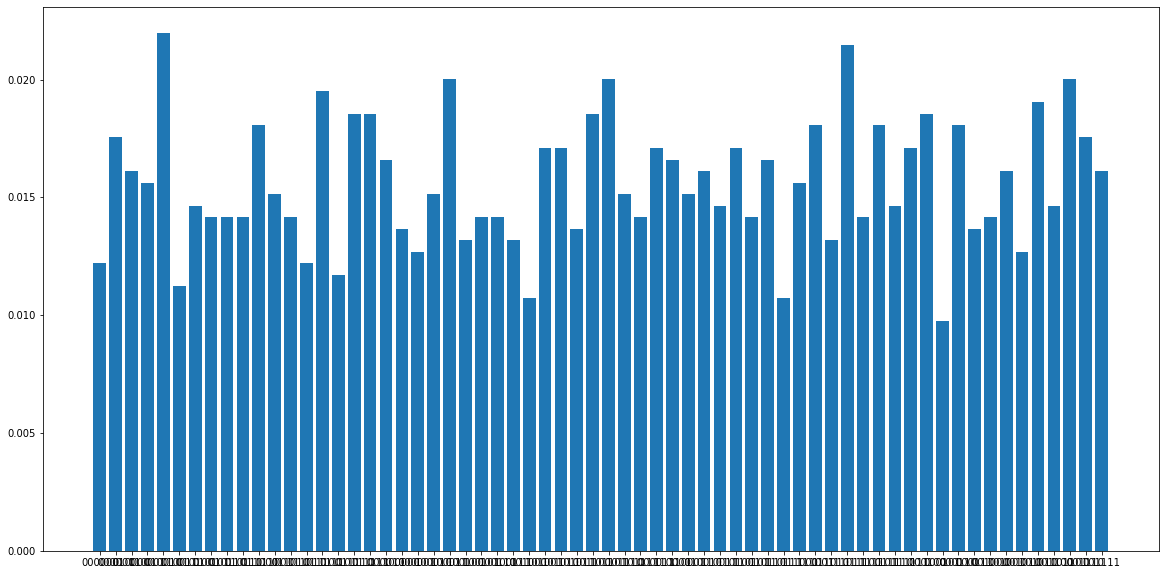

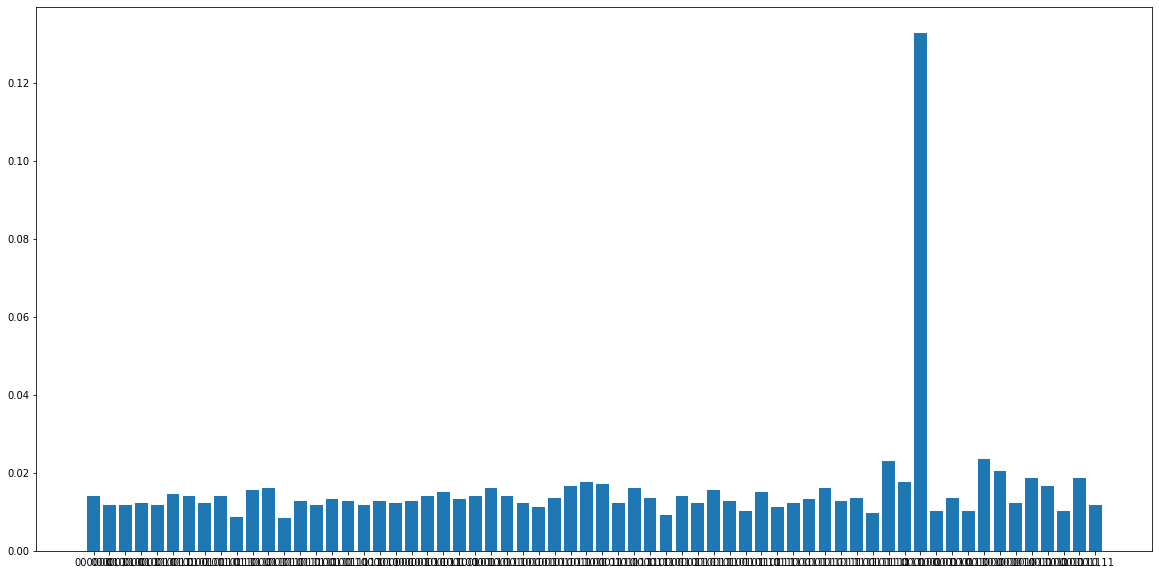

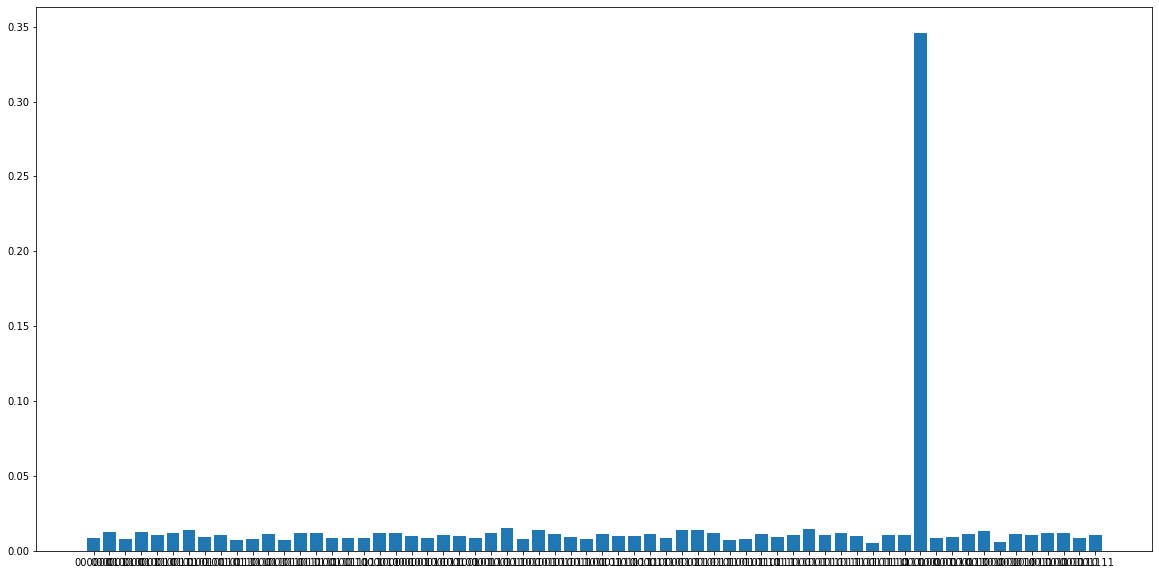

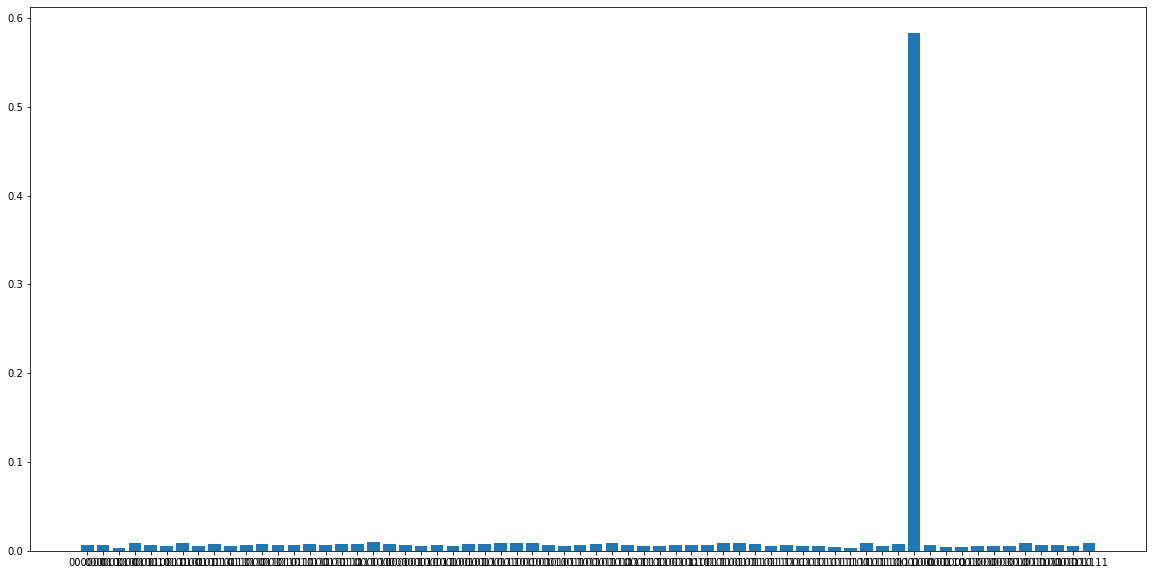

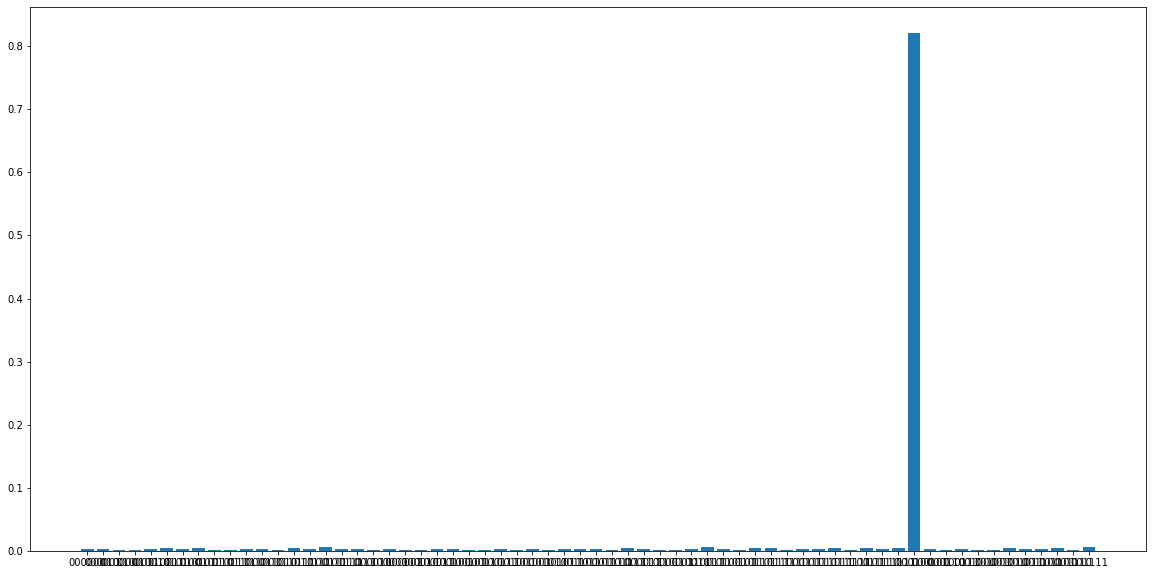

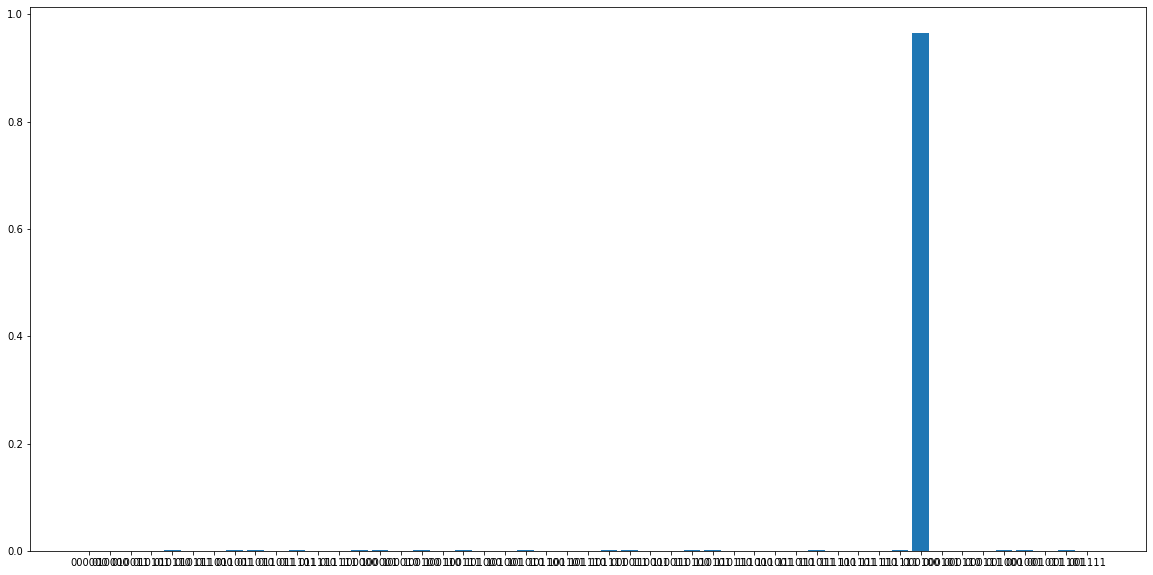

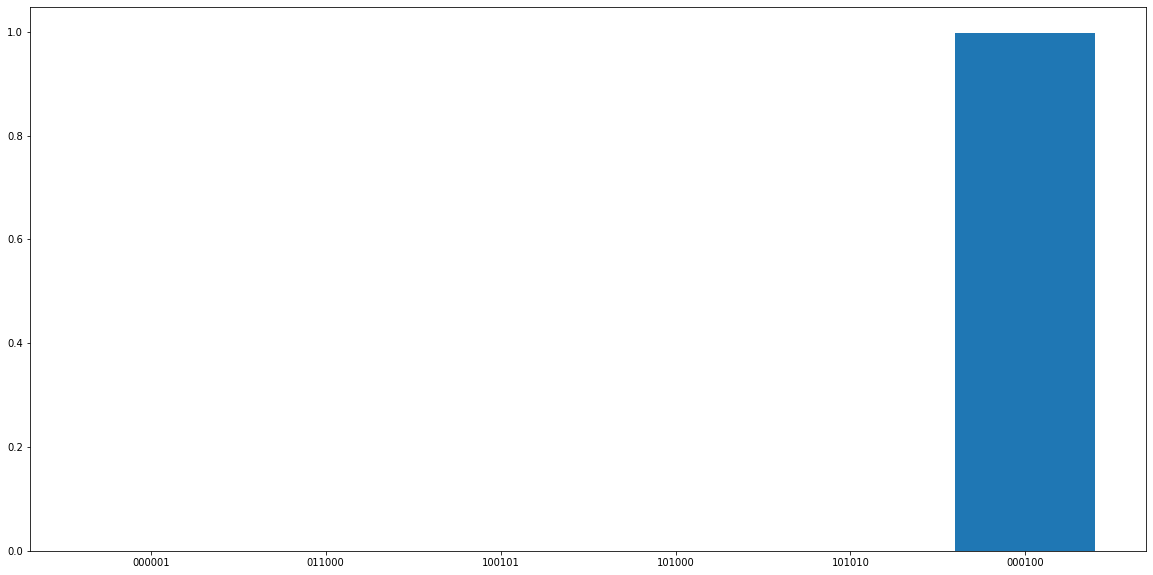

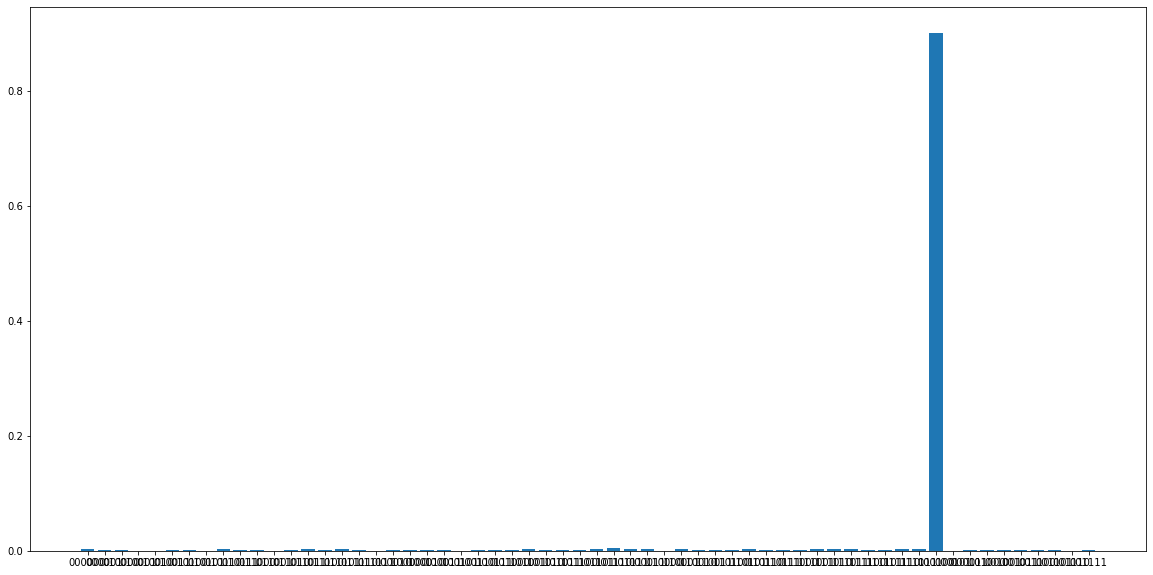

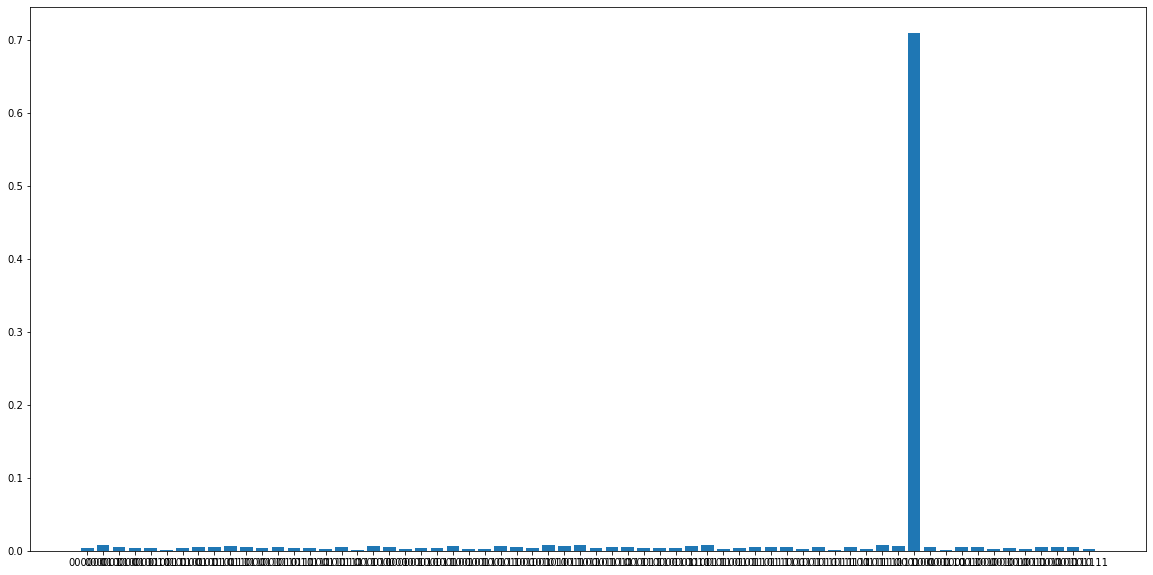

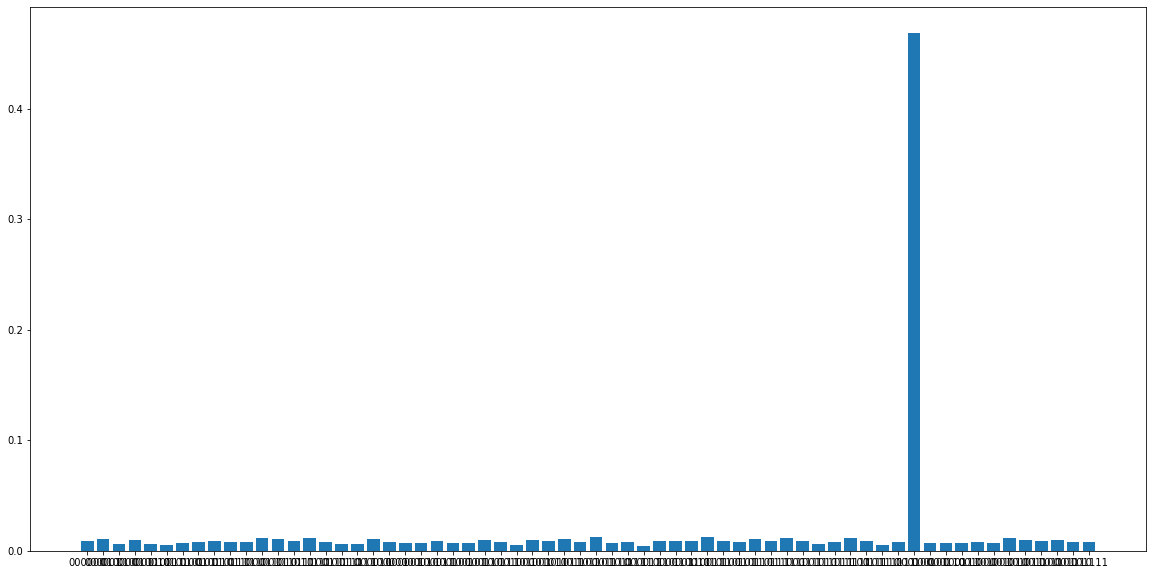

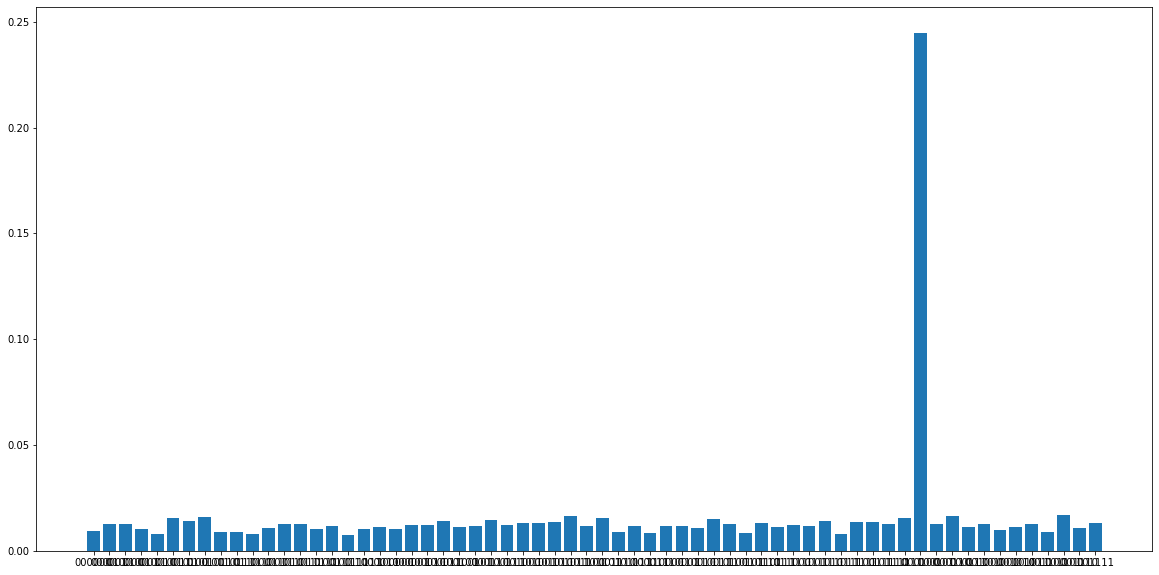

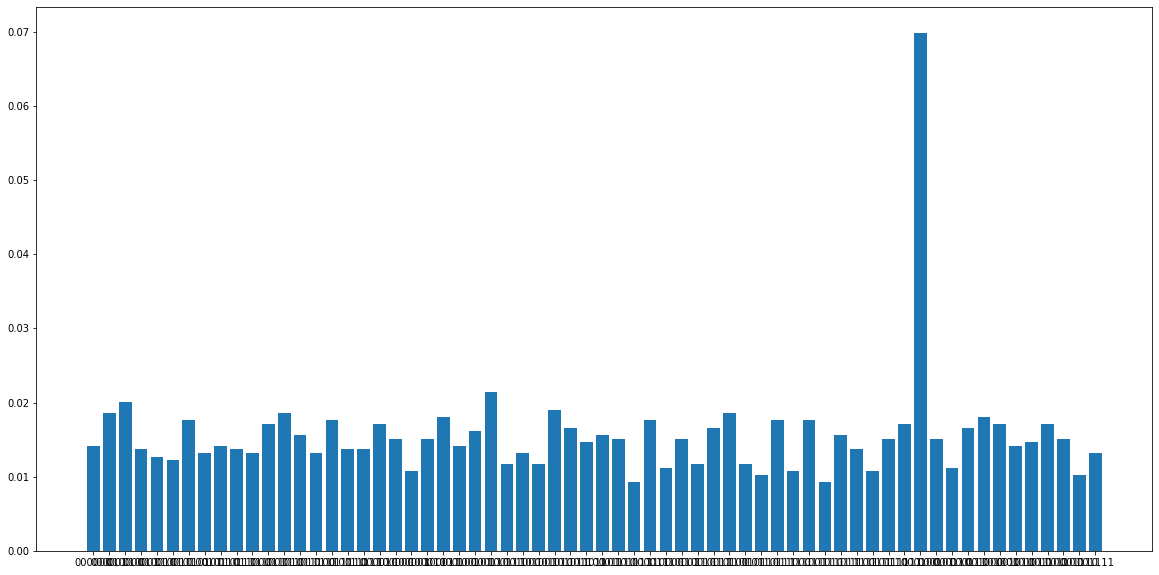

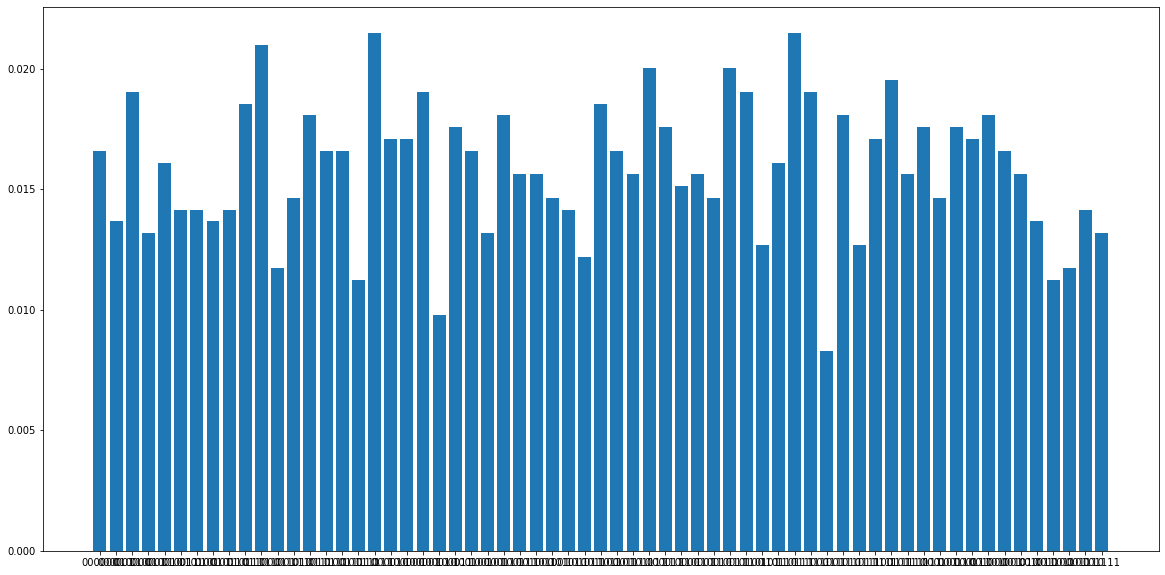

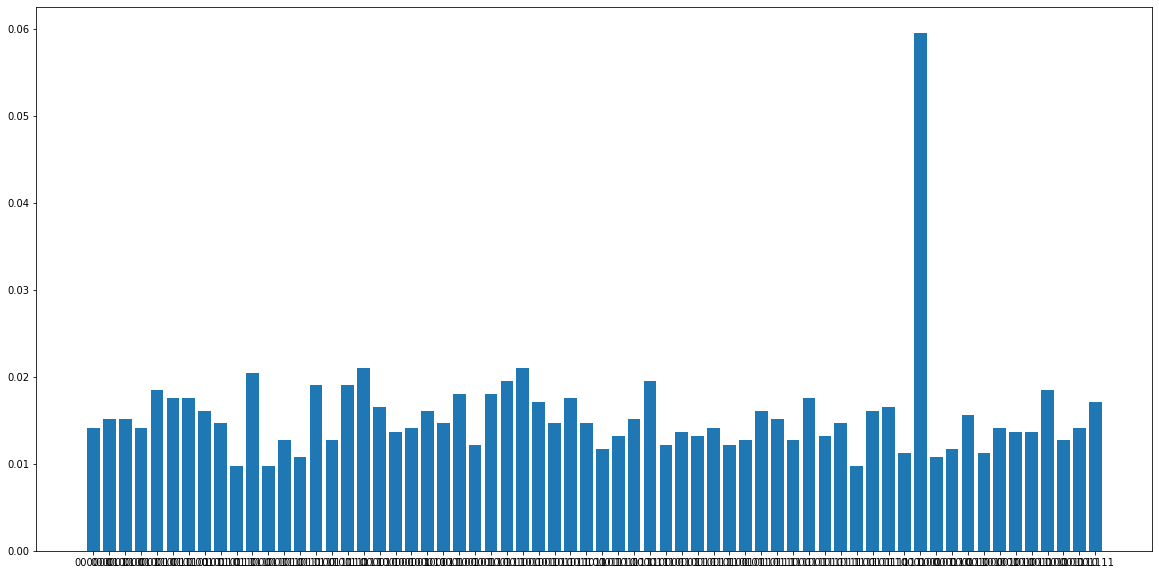

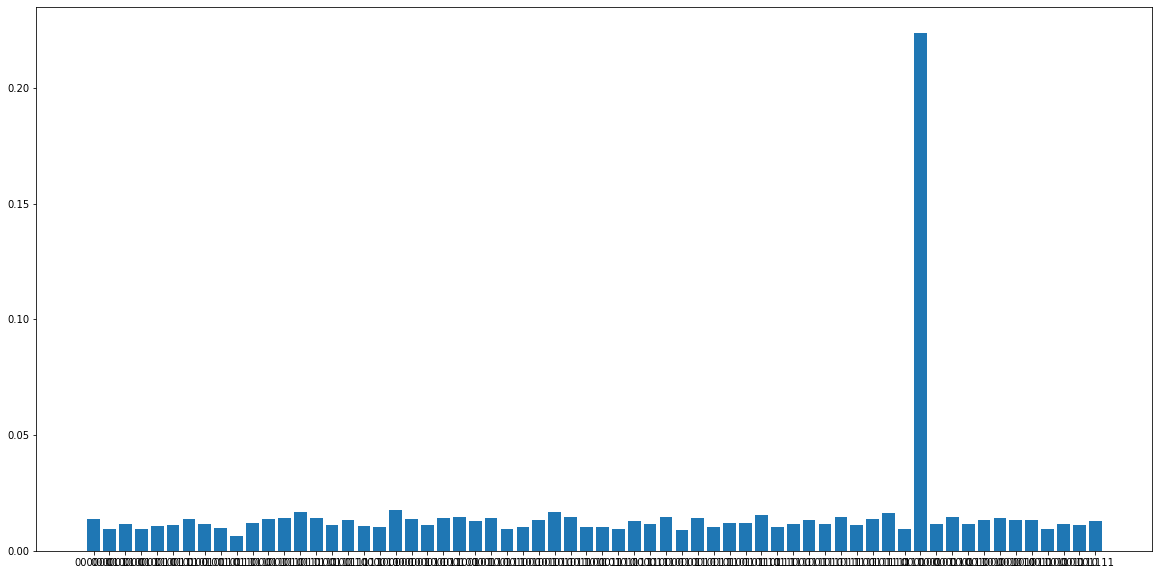

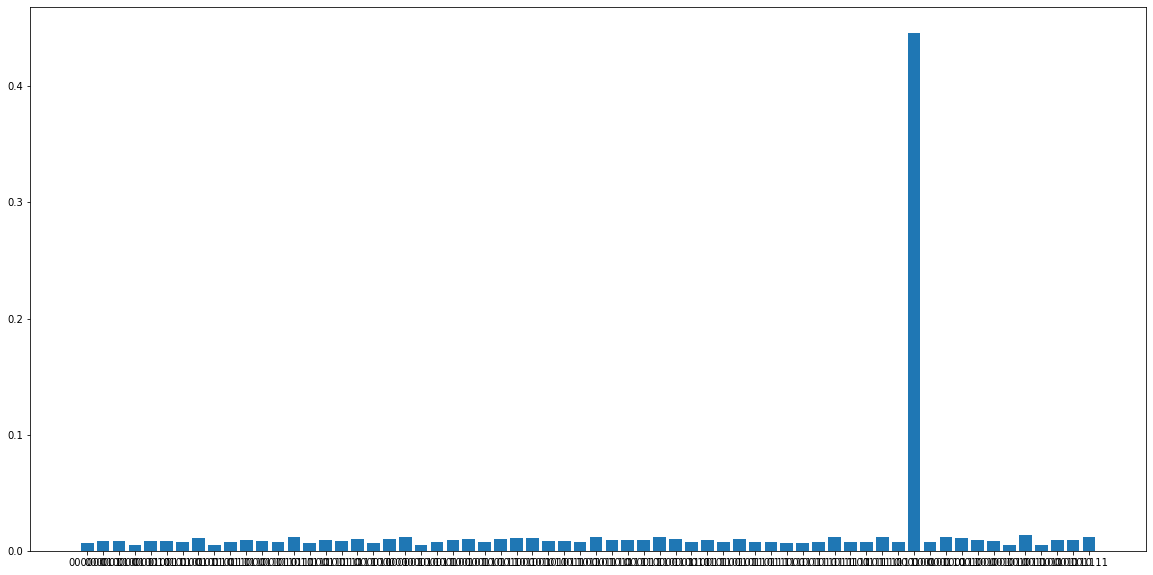

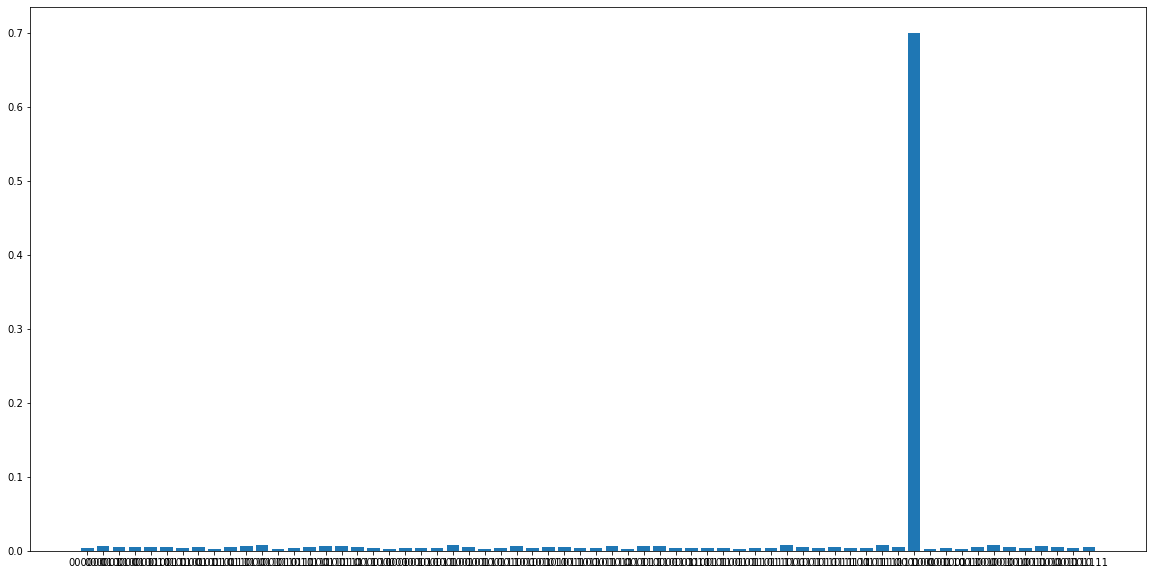

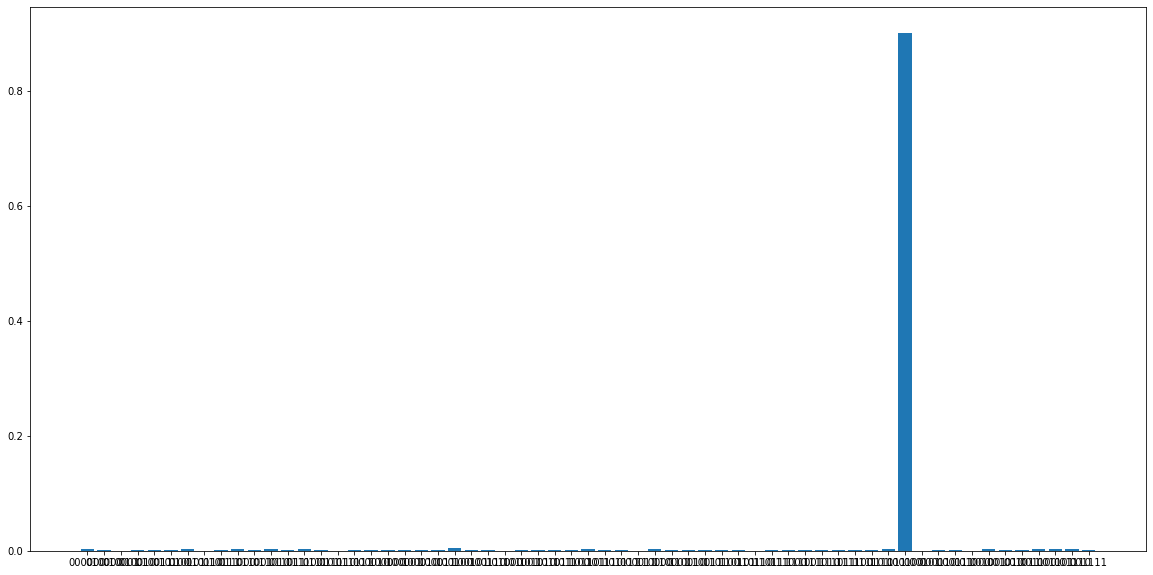

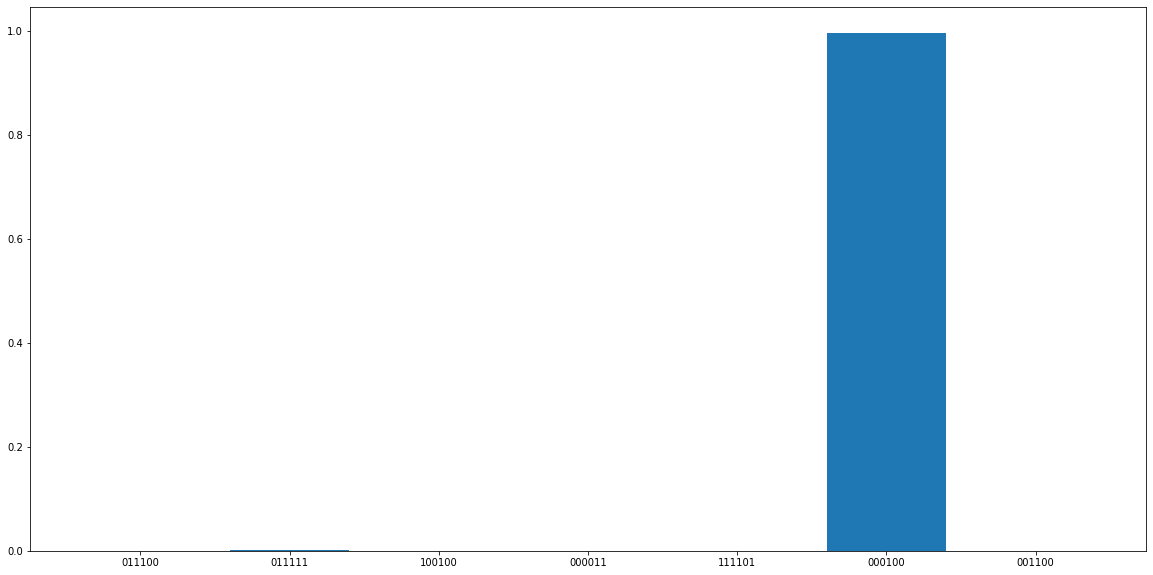

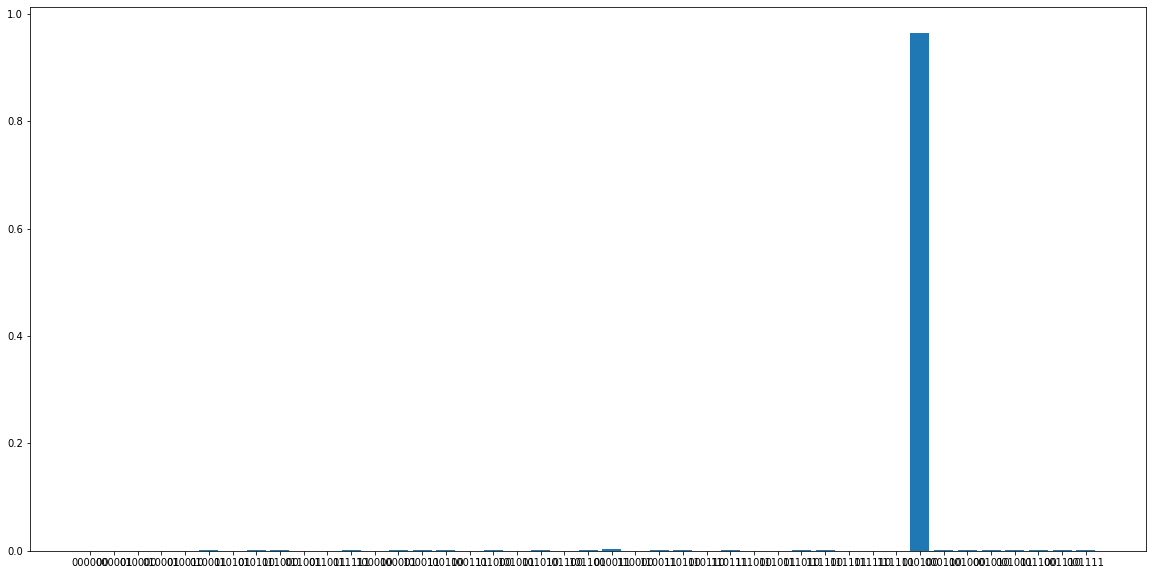

In [10]:
import matplotlib.pyplot as plt

key_plot = binary_input(data_in,n=n)
probs = []

for itt in np.arange(itts):
    #hist[itt] contains all the binary entry, which is a dictionary. * refers to key. this if is to determine if the desired tmplate has a counting
    if np.any(np.array([*hist[itt]])==key_plot):
        probs.append(hist[itt][key_plot])
    else:
        probs.append(0)
    fig = plt.figure(figsize=(20,10))
    plt.bar(hist[itt].keys(),np.array([hist[itt][key] for key in hist[itt].keys()])/2048.)
    plt.show()

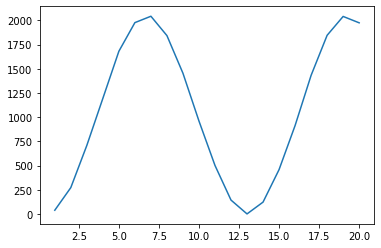

In [11]:
plt.plot(np.arange(1,itts+1),probs)
plt.show()

In [12]:
k=np.pi/(4*np.arcsin(1/np.sqrt(2**n)))-1/2
print(k)

5.766749819872207


In [13]:
#print(np.argmax(probs))

In [14]:
def sinosoid_2(x, A, B, C, f):
    #((2*k)+1)*theta=2*f*x+f+b k=x
    #2*f=2*theta f=theta
    return A*np.sin((2*x+1)*f+B)**2 + C

In [15]:
import scipy.optimize as optimize

xdata = np.arange(1,itts+1)
ydata = probs/np.max(probs)

p, pcov = optimize.curve_fit(sinosoid_2, xdata=xdata, ydata=ydata, p0=[1.,0.,0.,0.2])

print(p)
f=p[-1]

[ 0.29071746 -1.21133524  0.38342068  0.23690905]


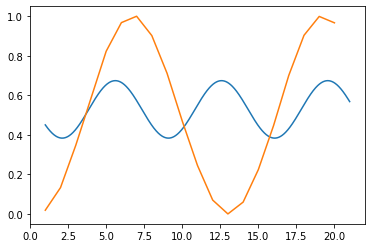

In [16]:
x=np.linspace(xdata[0],xdata[-1],1000)

plt.plot(np.linspace(1,itts+1,1000),sinosoid_2(x,p[0], p[1], p[2], p[3]))
plt.plot(np.arange(1,itts+1),ydata)

plt.show()

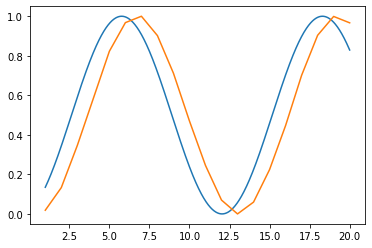

In [17]:
x=np.linspace(xdata[0],xdata[-1],1000)
theta=np.arcsin(1/np.sqrt(2**n))
y=np.sin(((2*x)+1)*theta)**2
plt.plot(x,y)
plt.plot(np.arange(1,itts+1),ydata)
#so Grovers working fine
plt.show()
#print (y)
#print(xdata)

In [18]:
N_t = int(np.round((2**n)*np.sin(f)**2))
print(N_t)

4


# Debugging counting

## see if controlled gates work

In [19]:
#setting up
n=2
nanc=1
a=n+nanc
p=3
data = QuantumRegister(n,'data')
counting=QuantumRegister(p,'counting')
templates=QuantumRegister(a,'templates')
result=ClassicalRegister(n,'result')
search_Circuit=QuantumCircuit(data,templates,counting,result)
data_in=2
data_in = binary_input(data_in,n=n)
for i,binary in enumerate(data_in[::-1]):
        if str(binary)=='1':
            search_Circuit.x(data[i])
search_Circuit.x(templates[n])
search_Circuit.h(templates[0:a]) 
search_Circuit.h(counting) 

In [20]:
GateCircuit=QuantumCircuit(data,templates)
GateCircuit=GroverGate(GateCircuit,n)
#GateCicuit.draw(output="mpl")  
G_Grover = GateCircuit.to_gate()
G_Grover.label = "GroverGate"
C_Grover = G_Grover.control()

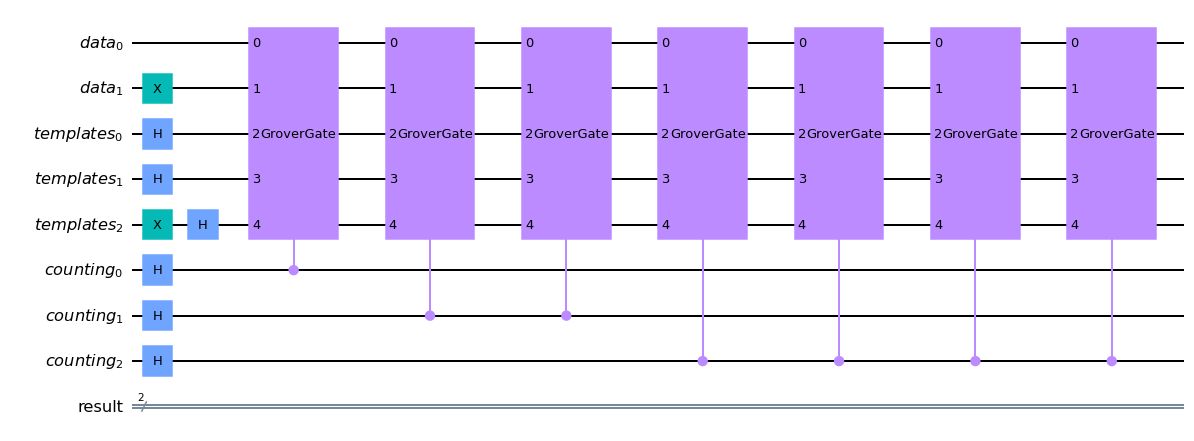

In [21]:
#the controlled Grover gate part in QPE
iteration=1
#looping through all the counting qubits
for countingqubit in np.arange(n+a,n+a+p):
    for i in np.arange(iteration):
        #this loop is to apply grovers 2^p times
        search_Circuit.append(C_Grover, [countingqubit]+[*range(0,n+a)])
    iteration *=2
search_Circuit.draw(output="mpl")
#the more bottom the later the qubit is. then in the matrix state vector it is stacked on the top

In [22]:
job = execute(search_Circuit, backend)
Matrix=job.result().get_unitary(search_Circuit, decimals=3)

In [23]:
print (Matrix.shape)

(256, 256)


In [24]:
countingMatrix=Matrix[:2**(p),:2**(p)]
print(countingMatrix)
#print (2**(n+a+p))

[[ 0.   +0.00000000e+00j  0.   +0.00000000e+00j  0.125-6.19616550e-16j
   0.   +0.00000000e+00j  0.   +0.00000000e+00j  0.   +0.00000000e+00j
   0.125-6.02573528e-16j  0.   +0.00000000e+00j]
 [ 0.   +0.00000000e+00j  0.   +0.00000000e+00j  0.   +0.00000000e+00j
   0.125-4.86363237e-16j  0.   +0.00000000e+00j  0.   +0.00000000e+00j
   0.   +0.00000000e+00j  0.125-6.73934970e-16j]
 [ 0.125-5.09922907e-16j  0.   +0.00000000e+00j  0.   +0.00000000e+00j
   0.   +0.00000000e+00j  0.125-8.15597369e-16j  0.   +0.00000000e+00j
   0.   +0.00000000e+00j  0.   +0.00000000e+00j]
 [ 0.   +0.00000000e+00j  0.125-3.79793620e-16j  0.   +0.00000000e+00j
   0.   +0.00000000e+00j  0.   +0.00000000e+00j  0.125-7.77430131e-16j
   0.   +0.00000000e+00j  0.   +0.00000000e+00j]
 [ 0.   +0.00000000e+00j  0.   +0.00000000e+00j  0.125-8.32677274e-16j
   0.   +0.00000000e+00j  0.   +0.00000000e+00j  0.   +0.00000000e+00j
  -0.125+9.09491382e-16j  0.   +0.00000000e+00j]
 [ 0.   +0.00000000e+00j  0.   +0.00000000e+0